In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/feedback-prize-english-language-learning/train.csv")
test_data = pd.read_csv("/kaggle/input/feedback-prize-english-language-learning/test.csv")

In [3]:
train_data.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [6]:
train_data.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [7]:
train_data.shape

(3911, 8)

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


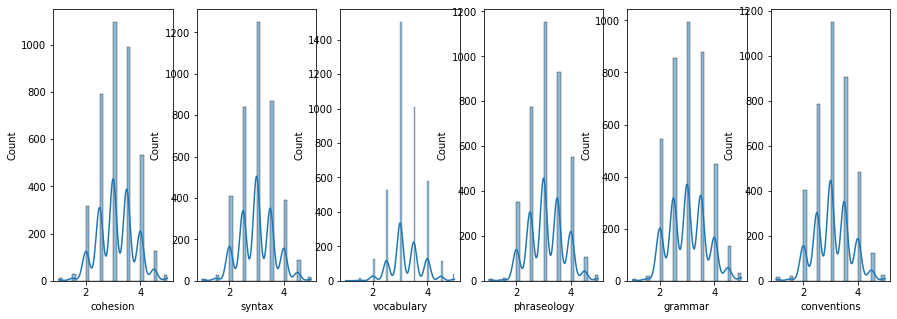

In [4]:
## Check label distributions ##
import matplotlib.pyplot as plt
import seaborn as sns

labels = train_data.iloc[:,2:]

fig,ax = plt.subplots(1,6,figsize=(15,5))
for i in range(6):
    sns.histplot(labels.iloc[:,i],ax=ax[i],kde=True)
fig.savefig("metric-dist.png")

Some info about the labels:
* The word “cohesion” loosely means “sticking together.” In English grammar, it is the logical linking of ideas and events within a sentence. There must be a flow between the clauses of a statement for writing to be well understood.
* Syntax is the part of grammar that focuses on how words are combined to form phrases and clauses and how those components are then arranged into meaningful sentences
* Vocabulary refers to the different kinds of words used
* Phraselogy refers to a manner of organizing words and phrases into longer elements
* Grammar score refers to the right use of words at the right places.
* Conventions include spelling, punctuation, capitalization, grammar, and sentence structure.

Sources: https://www.english.cam.ac.uk/elor/lo/cohesion/index.html#:~:text=Cohesion%20refers%20to%20the%20many,that%20is%2C%20make%20no%20sense.

https://www.merriam-webster.com/dictionary/phraseology#:~:text=Definition%20of%20phraseology,2%20%3A%20choice%20of%20words

https://prowritingaid.com/grammar-vs-syntax#:~:text=it%20for%20free!-,Definition%20%26%20Meaning%20of%20Syntax,%2C%20or%20compound%2Dcomplex%20sentences.


Let's check the number of words per essay

In [6]:
num_words = train_data["full_text"].apply(lambda x: len(word_tokenize(x)))
print("Essay with maximum number of words: ",max(num_words))
print("Essay with minimum number of words: ",min(num_words))
train_data["num_words"] = num_words

Essay with maximum number of words:  1357
Essay with minimum number of words:  14


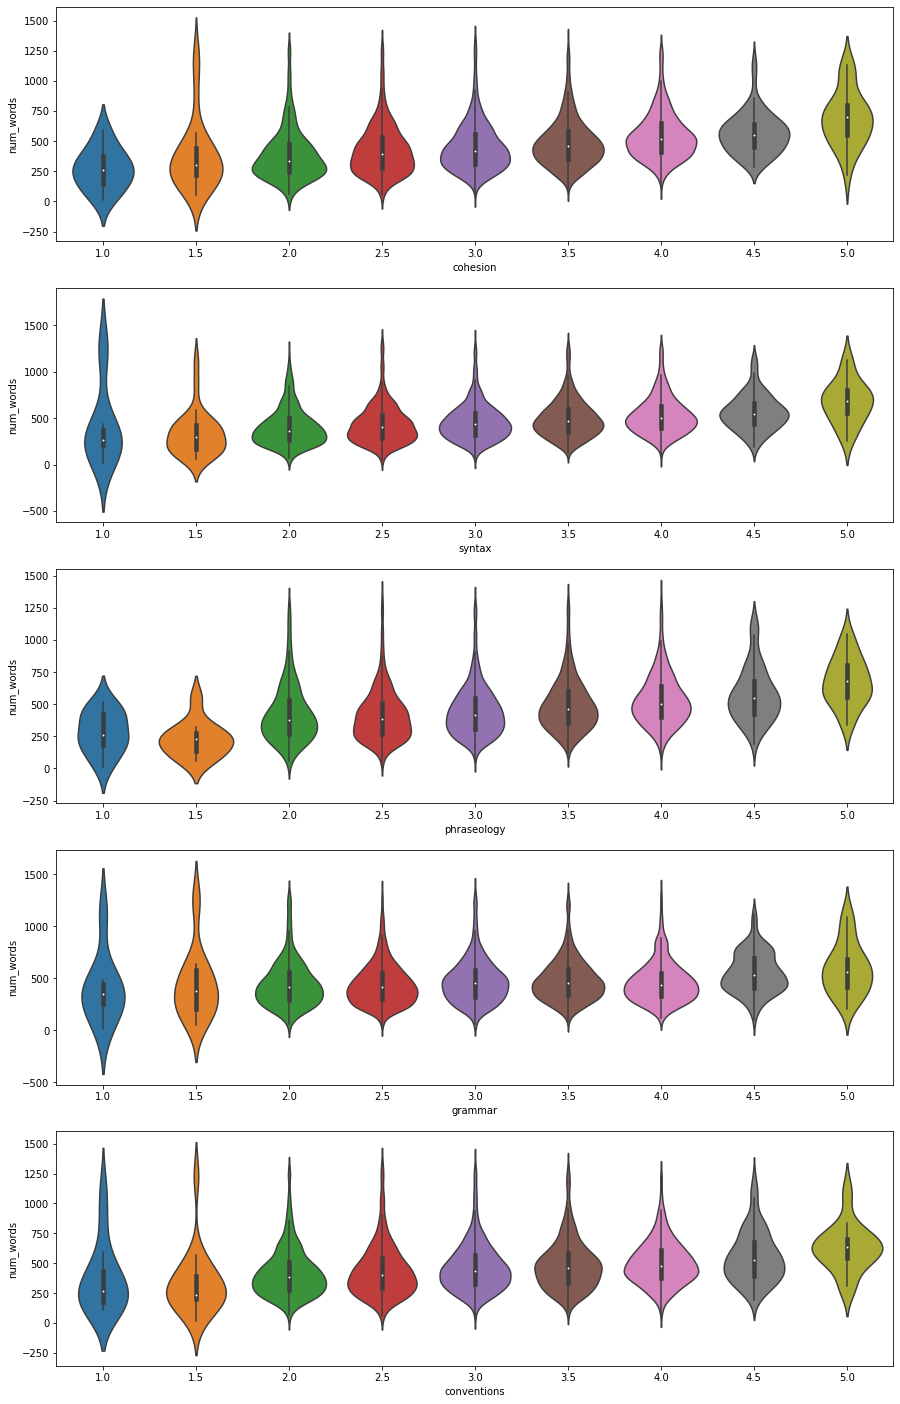

In [7]:
import plotly.express as px
fig,ax = plt.subplots(5,1,figsize=(15,25))
cols = labels.columns
k=0
for i in range(6): 
    if cols[i]!="vocabulary":
        sns.violinplot(data=train_data,x=cols[i],y="num_words",ax=ax[k])
        k+=1


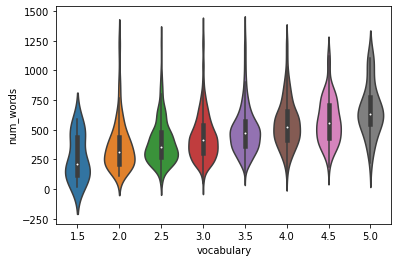

In [10]:
sns.violinplot(x=train_data["vocabulary"][train_data.vocabulary>1.0],y=train_data["num_words"])
plt.show()

We can't make a clear distinctio but if viewed carefully there is a clear upward trend of the mean which points to the fact that maybe essays with more words tend to be graded better

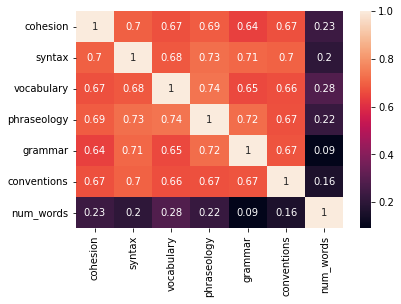

In [13]:
def get_heatmap(df,feat):
    corr_df = df.loc[:,["cohesion","syntax","vocabulary","phraseology","grammar","conventions"]]
    corr_df[feat] = df[feat]
    sns.heatmap(corr_df.corr(),annot=True)
    plt.savefig("word-count-heatmap.png")
    plt.show()

get_heatmap(train_data,"num_words")

But we see that num_words feature and the labels do not seem to be highly correlated

Now let's see if the words used are longer: does it make our grades better?

In [18]:
def get_avg_word_length(x):
    words = word_tokenize(x)
    avg = 0
    for word in words:
        avg+=len(word)
    return avg/len(words)
train_data["word_length"] = train_data["full_text"].apply(get_avg_word_length)

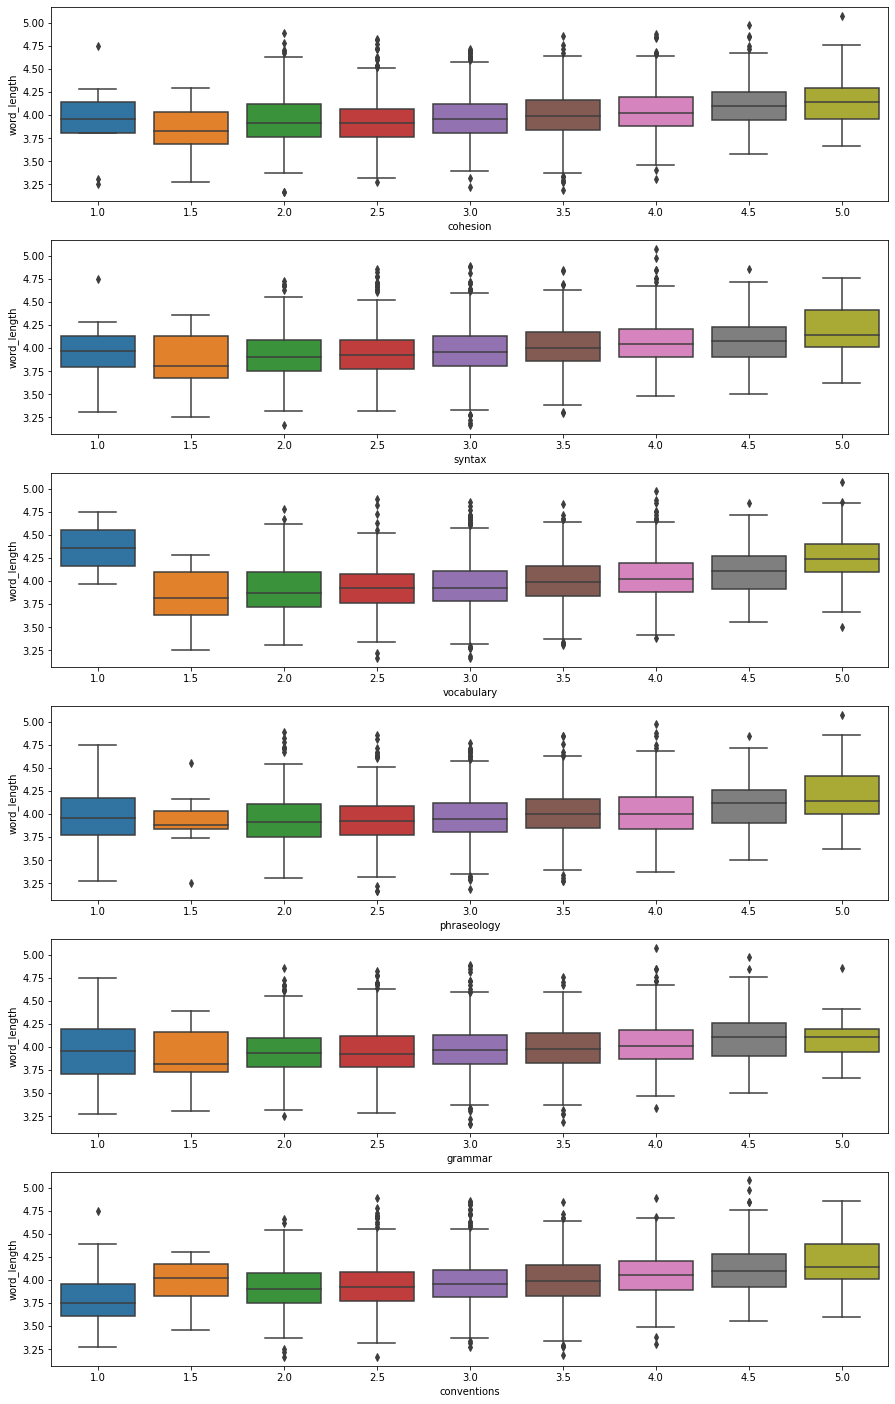

In [19]:
def plot_across_labels(train_data,y,type="box"):
    fig,ax = plt.subplots(6,1,figsize=(15,25))
    cols = labels.columns
    for i in range(6):
        if type=="box":
            sns.boxplot(data=train_data,x=cols[i],y=y,ax=ax[i])
        elif type=="violin":
            sns.violinplot(data=train_data,x=cols[i],y=y,ax=ax[i])

plot_across_labels(train_data,"word_length")

We again see an increasing trend in almost all metrics. We get a sense that using lengthy words leads to a better scoring essay

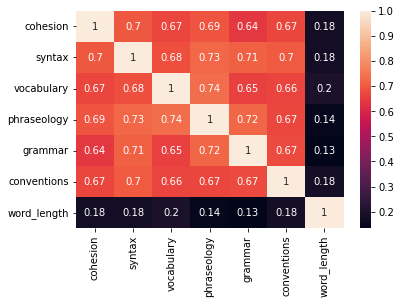

In [20]:
get_heatmap(train_data,"word_length")

Now we can check if repeating words leads to a better scored essay

Again, we don't really find a high correlation

In [21]:
from collections import Counter
def get_avg_word_reps(x):
    words = x.split()
    c_dict = Counter(words)
    sum_reps = 0
    for k in c_dict.keys():
        sum_reps+=(c_dict[k]-1)
    return sum_reps/len(words)

train_data["average_word_reps"] = train_data["full_text"].apply(get_avg_word_reps)

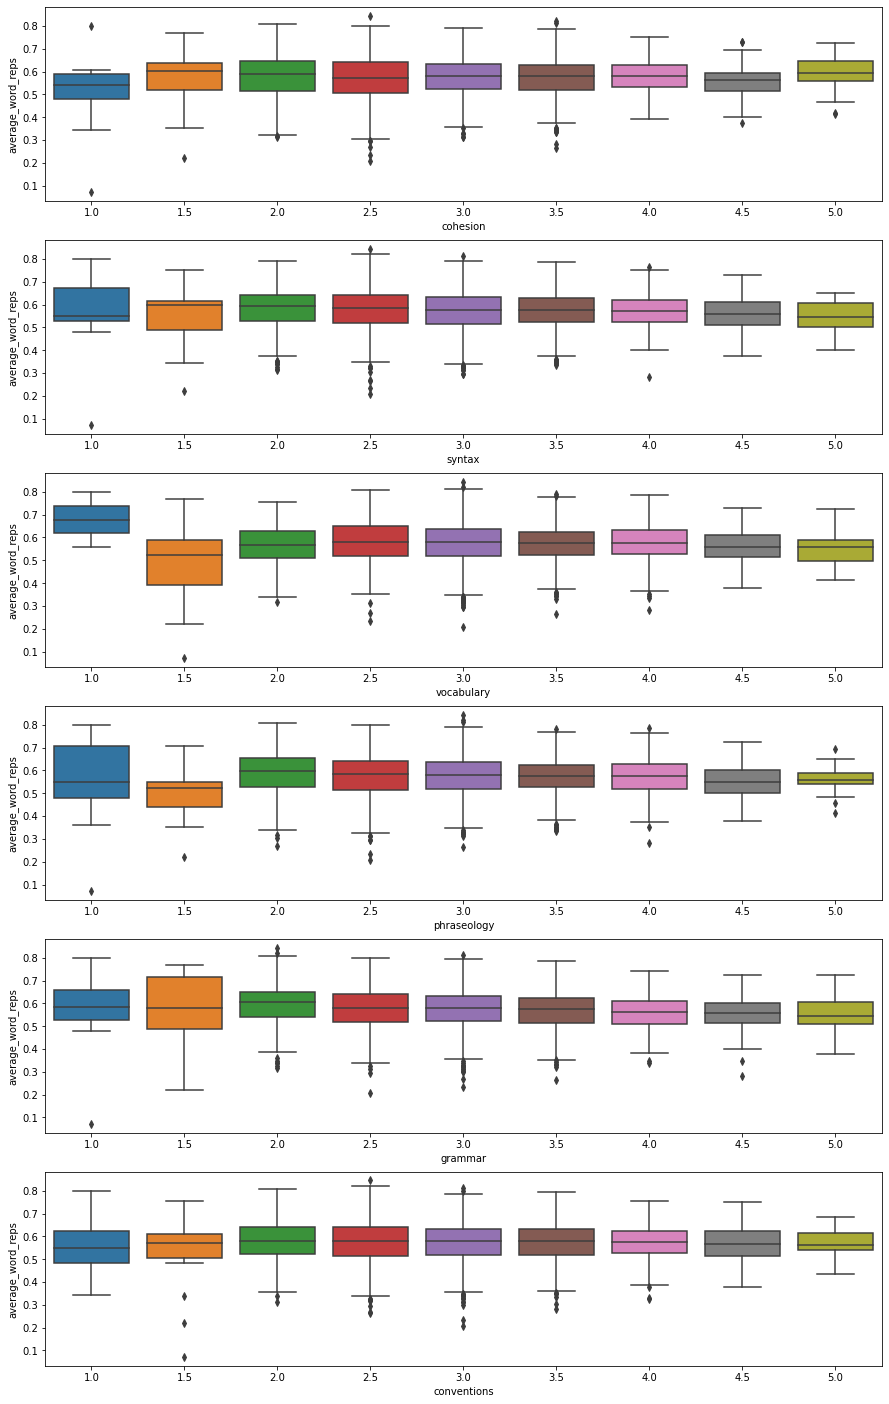

In [22]:
plot_across_labels(train_data,"average_word_reps")

Don't see a trend here

In [24]:
def get_num_stopwords(x):
    words = word_tokenize(x)
    stop_words = set(stopwords.words('english'))
    sw_count = 0
    for w in words:
        if w.lower() in stop_words:
            sw_count+=1
    return sw_count

train_data["stopword_count"] = train_data.full_text.apply(get_num_stopwords)
            

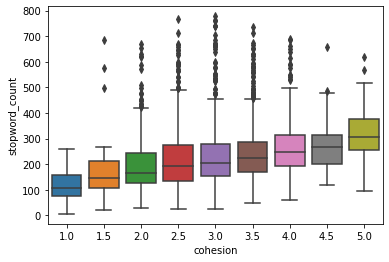

In [26]:
sns.boxplot(data=train_data,x="cohesion",y="stopword_count")
plt.savefig("stopword_vs_cohesion.png")

Let's see how using more stop words affects the grade

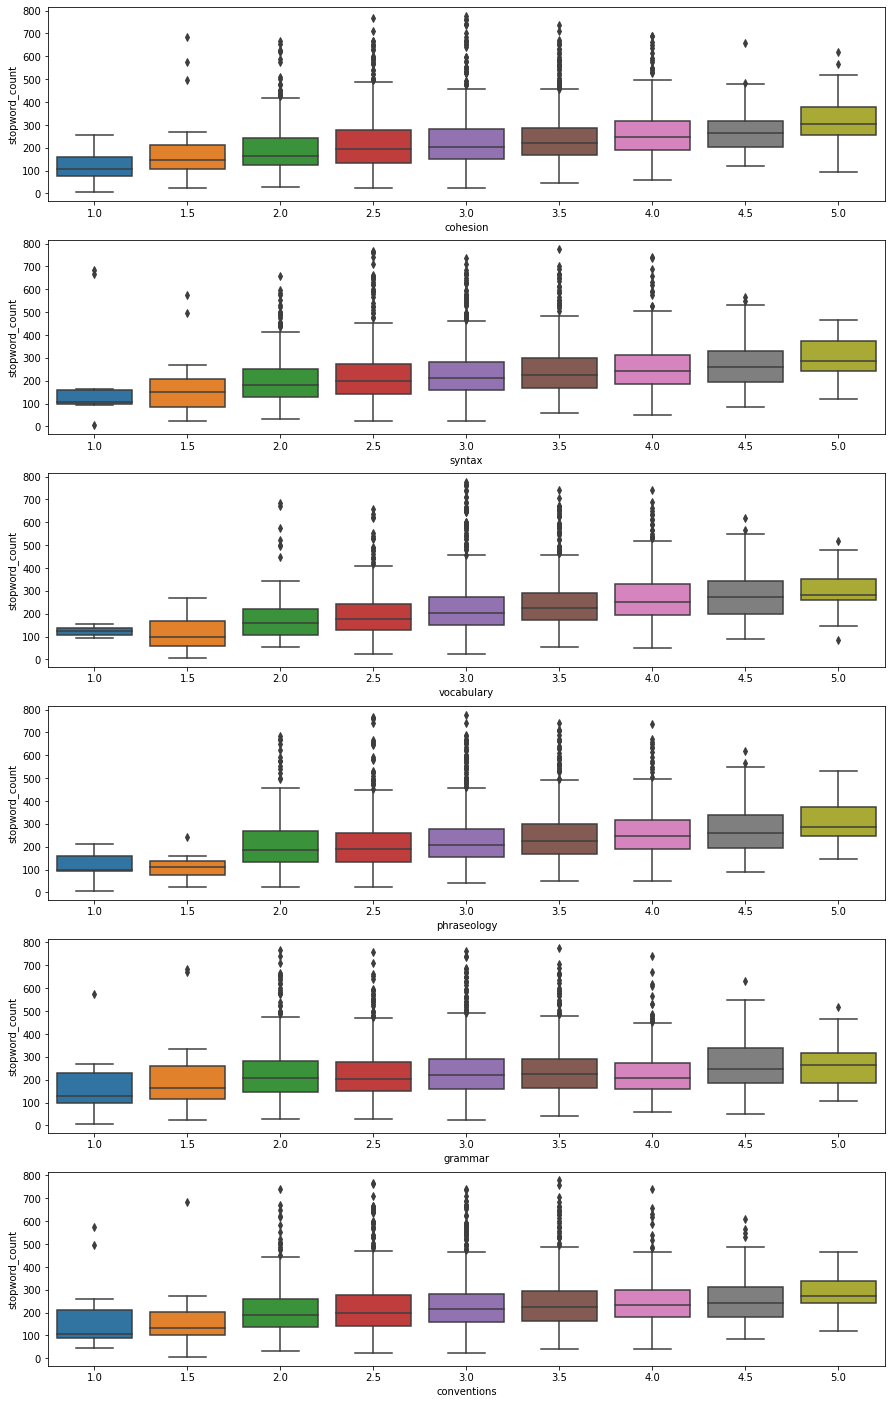

In [18]:
plot_across_labels(train_data,"stopword_count")

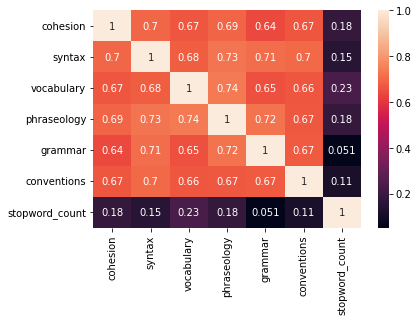

In [19]:
get_heatmap(train_data,"stopword_count")

We can check if the association of word count, word length, reptitions changes on removing the stopwords from the text

In [20]:
def get_cleaned_word_counts(x):
    words = word_tokenize(x)
    stopw = set(stopwords.words('english'))
    cleaned_words = [w for w in words if w.lower() not in stopw]
    return len(cleaned_words)
    
train_data["cleaned_word_count"] = train_data["full_text"].apply(get_cleaned_word_counts)

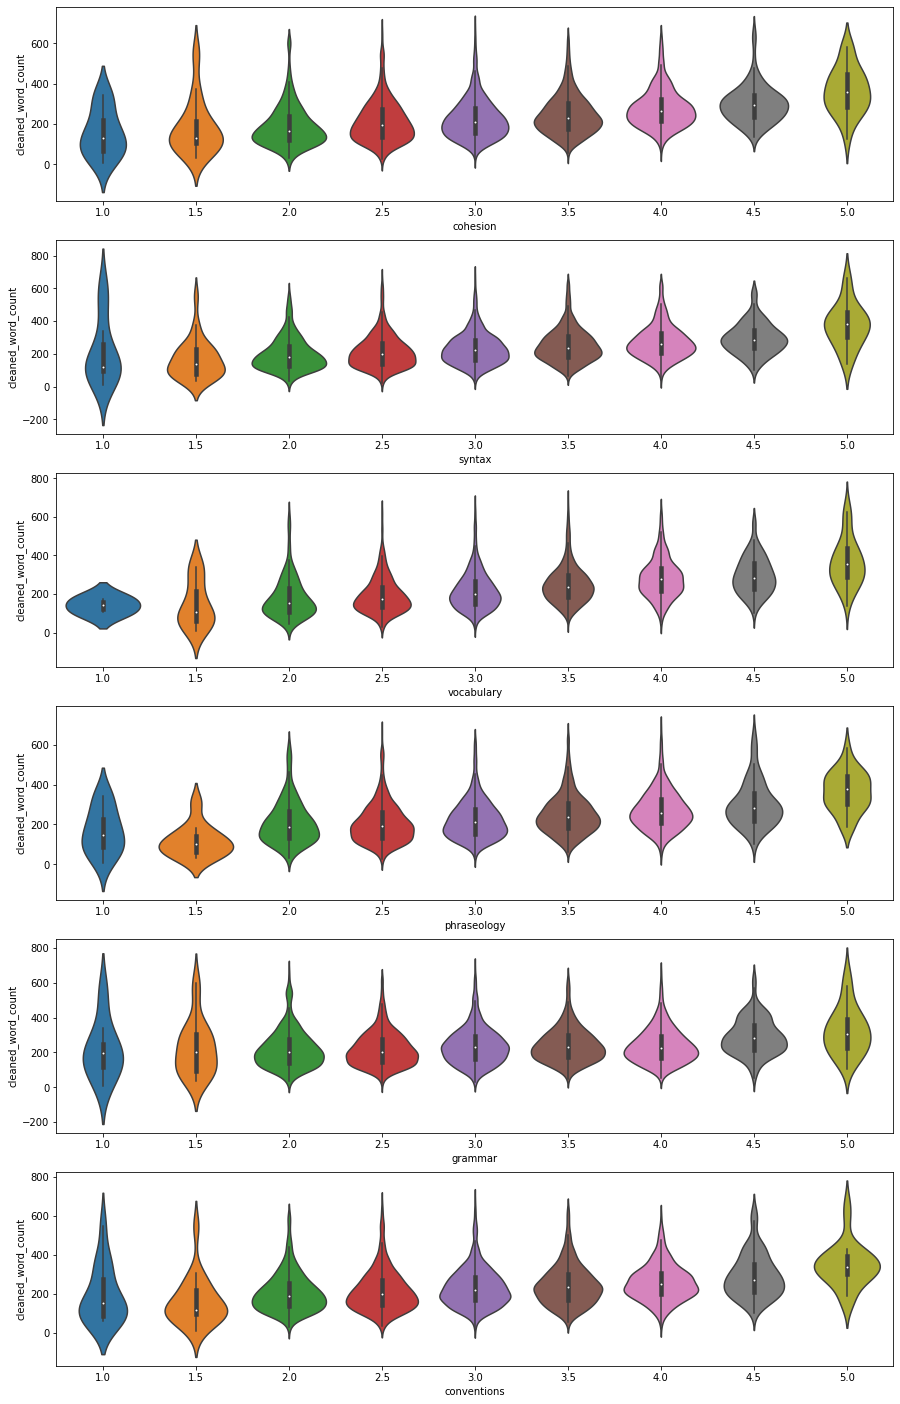

In [21]:
plot_across_labels(train_data,"cleaned_word_count",type="violin")

We see a slightly more increasing trend in this case, doing the same for word_length

In [22]:
def get_cleaned_word_lengths(x):
    words = word_tokenize(x)
    stopw = set(stopwords.words('english'))
    cleaned_words = [len(w)for w in words if w.lower() not in stopw]
    
    return sum(cleaned_words)/len(cleaned_words)
train_data["cleaned_word_lengths"] = train_data["full_text"].apply(get_cleaned_word_lengths)

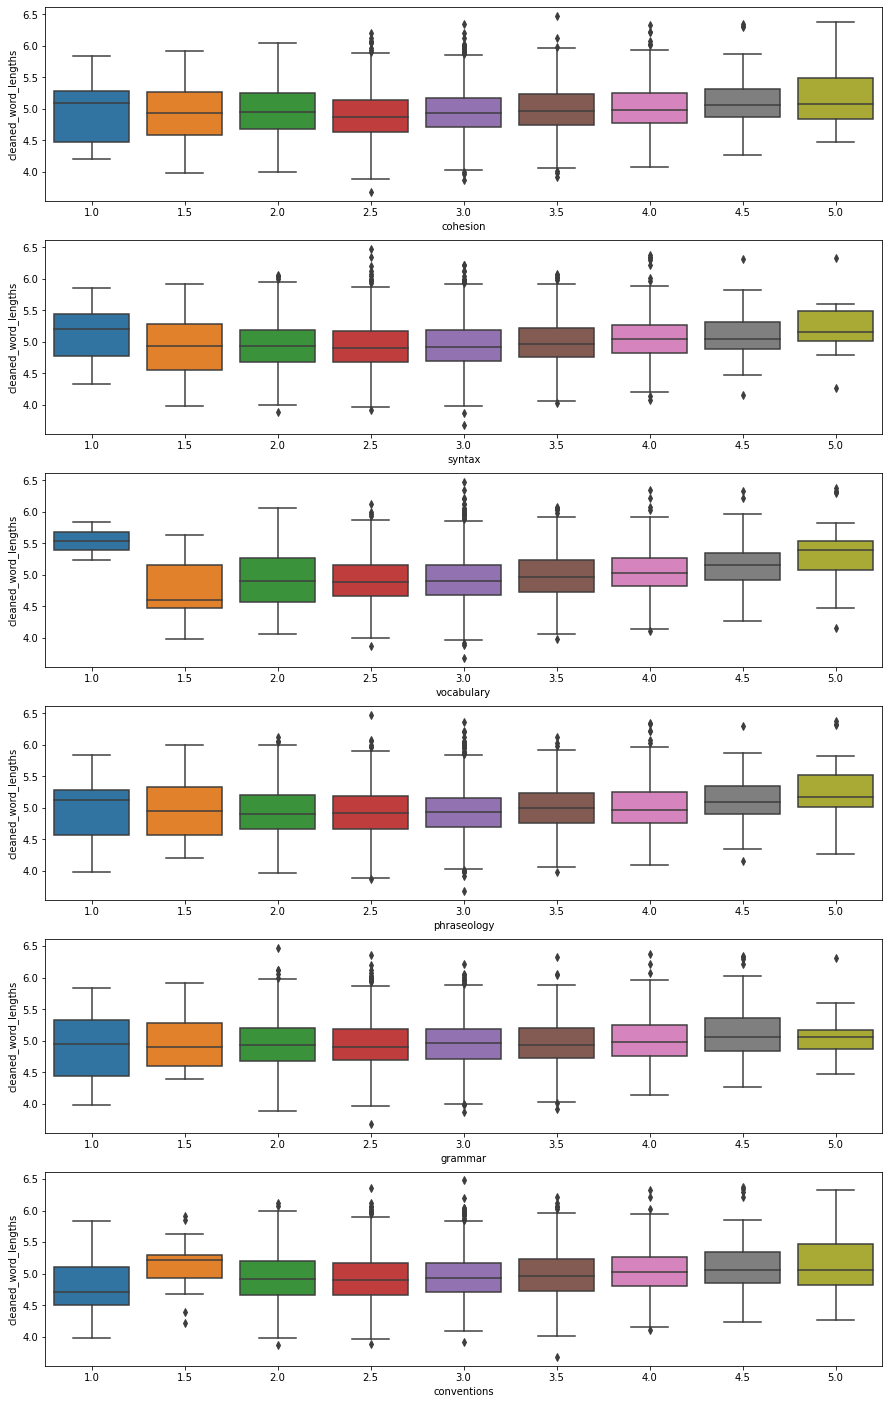

In [23]:
plot_across_labels(train_data,"cleaned_word_lengths")

The trend vanishes as all categories show a similar average word length

Let's look at the metrics from a sentence level

In [24]:
def get_sentence_length(x):
    sentence = sent_tokenize(x)
    return len(sentence)

train_data["sen_length"] = train_data.full_text.apply(get_sentence_length)

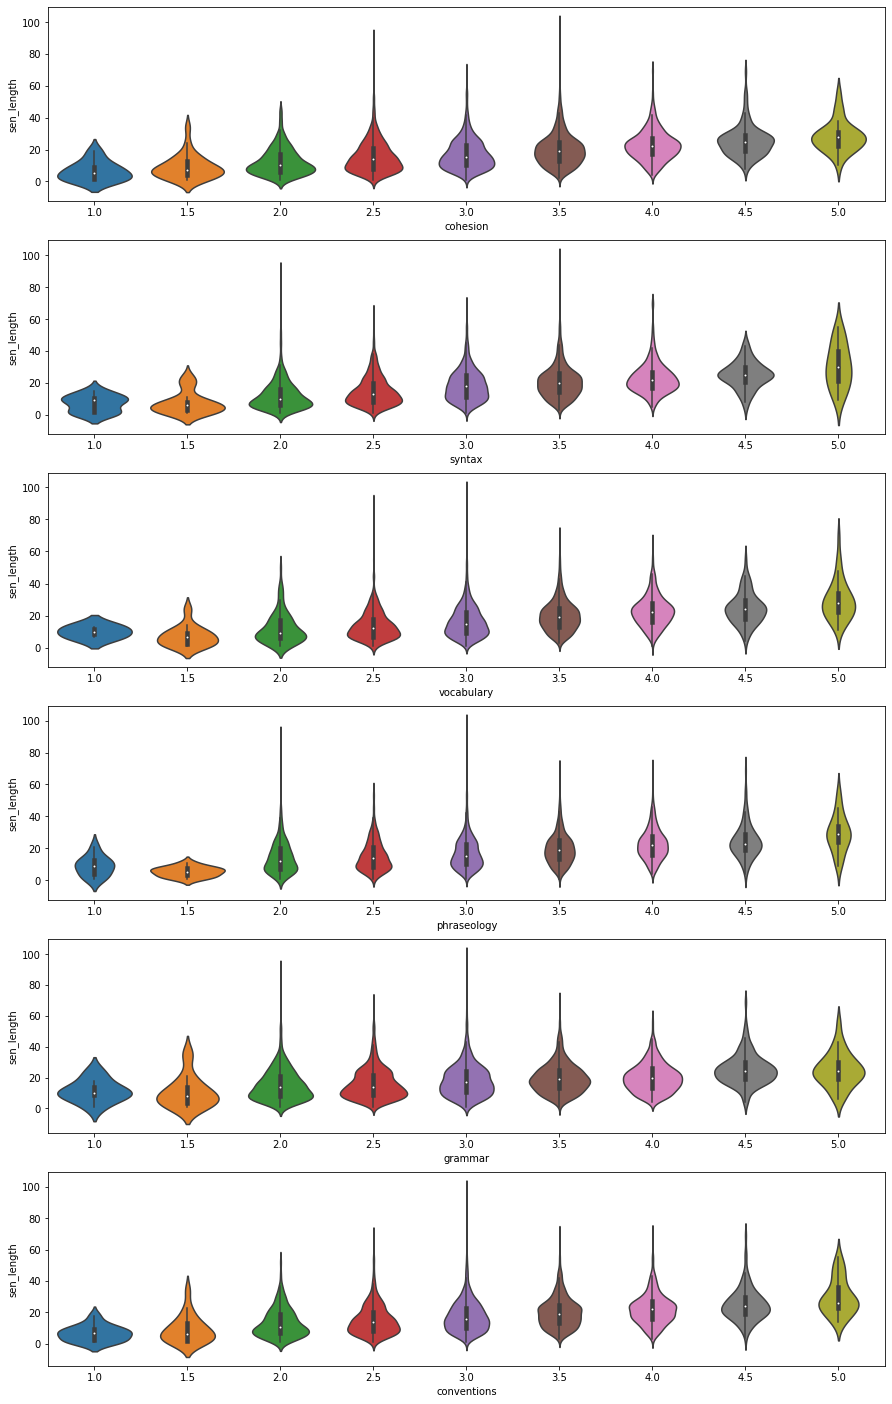

In [25]:
plot_across_labels(train_data,"sen_length",type="violin")

While we see a slightly increasing trend in the means, there are extremeties found in class 3.0

Reading Ease: There are many metrics that help us understand how readable a piece of text is

In [26]:
!pip install py-readability-metrics

In [29]:
from readability import Readability

def get_flesch_reading_ease(x):
    words = word_tokenize(x)
    if len(words)>150:
        r = Readability(x)
        f = r.flesch()
        return f.score
    else:
        return 0

train_data["flesch"] = train_data.full_text.apply(get_flesch_reading_ease)

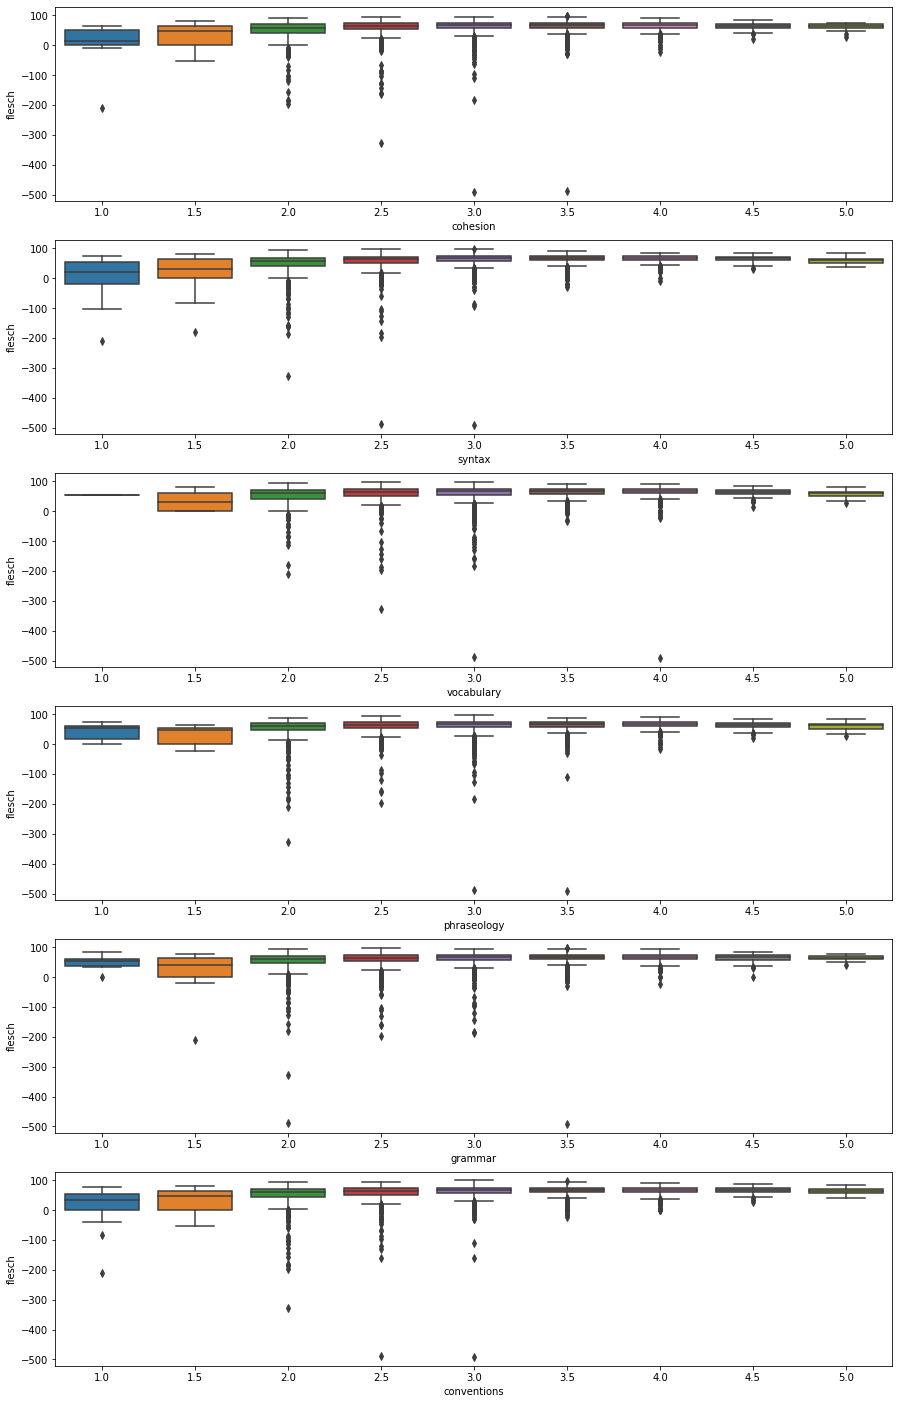

In [32]:
plot_across_labels(train_data,"flesch")

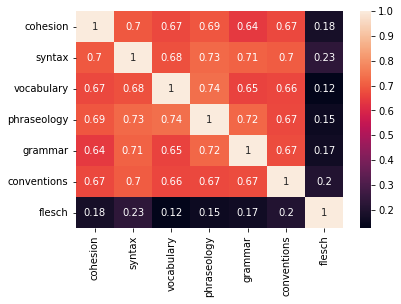

In [33]:
get_heatmap(train_data,"flesch")